In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
import os
sys.path.insert(1, os.path.realpath(os.path.pardir))
sys.path.append("../node2vec2rank/")
import pandas as pd
import numpy as np

In [2]:
tissue = 'PRAD'
target = 'caseVScontrol'
network_inf_method = 'GIRAFFE'
ora_exp_parent_folder_name = 'GIRAFFE_comparison'
save_gsea_results_notes = ''

In [3]:
config = {'save_dir': '../output',
 'data_dir': '../data/prad',
 'graph_filenames': ['network_case.tsv', 'network_control.tsv'],
 'separator': '\t',
 'is_edge_list': False,
 'transpose': False,
 'project_unipartite_on': "rows",
 'threshold': None,
 'top_percent_keep': 100,
 'binarize': False,
 'absolute': False,
 'embed_dimensions': [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24],
 'distance_metrics': ['euclidean', 'cosine'],
 'seed': 42,
 'comp_strategy': 'sequential',
 'verbose': 1}

In [4]:
from node2vec2rank.dataloader import DataLoader

dataloader = DataLoader(config=config)
graphs = dataloader.get_graphs()
nodes = dataloader.get_nodes()

Loading graphs in memory ...
	There are 17873 row nodes and 644 column nodes in graph 1
	There are 17873 row nodes and 644 column nodes in graph 2
	Graphs are non-square and will be projected on row nodes
	There are 17873 common nodes and resulting networks will have size 17873 by 17873
Transforming graphs ...
	 to_unipartite
Finished loading in 32.57 seconds 



In [5]:
from node2vec2rank.model import N2V2R
model = N2V2R(graphs=graphs, config=config, nodes=nodes)

../output/03_23_2024_12_02_12


In [6]:
rankings = model.fit_transform_rank()
borda_ranking = model.aggregate_transform()
DeDi_rankings = model.degree_difference_ranking()


Running n2v2r with dimensions [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24] and distance metrics ['euclidean', 'cosine'] ...
	Multi-layer embedding in 159.71 seconds
n2v2r computed 22 rankings for 1 comparison(s) in 164.21 seconds

Rank aggregation with Borda ...
	Finished aggregation in 8.8 seconds


In [7]:
comparison = '1'
n2v2r_borda_ranking_pd = borda_ranking[comparison].copy()
absDeDi_ranking_pd = DeDi_rankings[comparison][['absDeDi']].copy()

gencode_fn = '../data/gene_set_libraries/human/gen_v26_mapping.csv'
gencode = pd.read_csv(gencode_fn, index_col=0)
ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
              for k, i in gencode.iterrows()}
genes_mapped = [ens2symbol[x] if x in ens2symbol else x for x in dataloader.interest_nodes ]

n2v2r_borda_ranking_pd.index = genes_mapped
absDeDi_ranking_pd.index = genes_mapped

## GSEA on GOBP

2024-03-23 12:08:00,270 [WARNING] Duplicated values found in preranked stats: 3.35% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-03-23 12:10:25,826 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


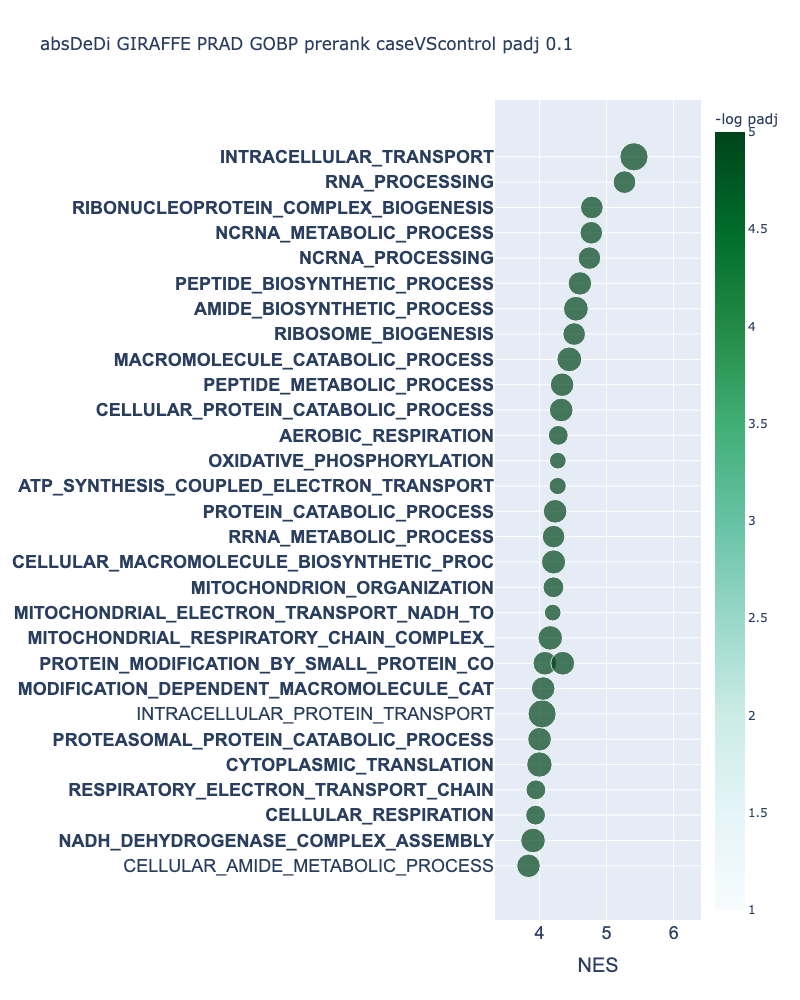

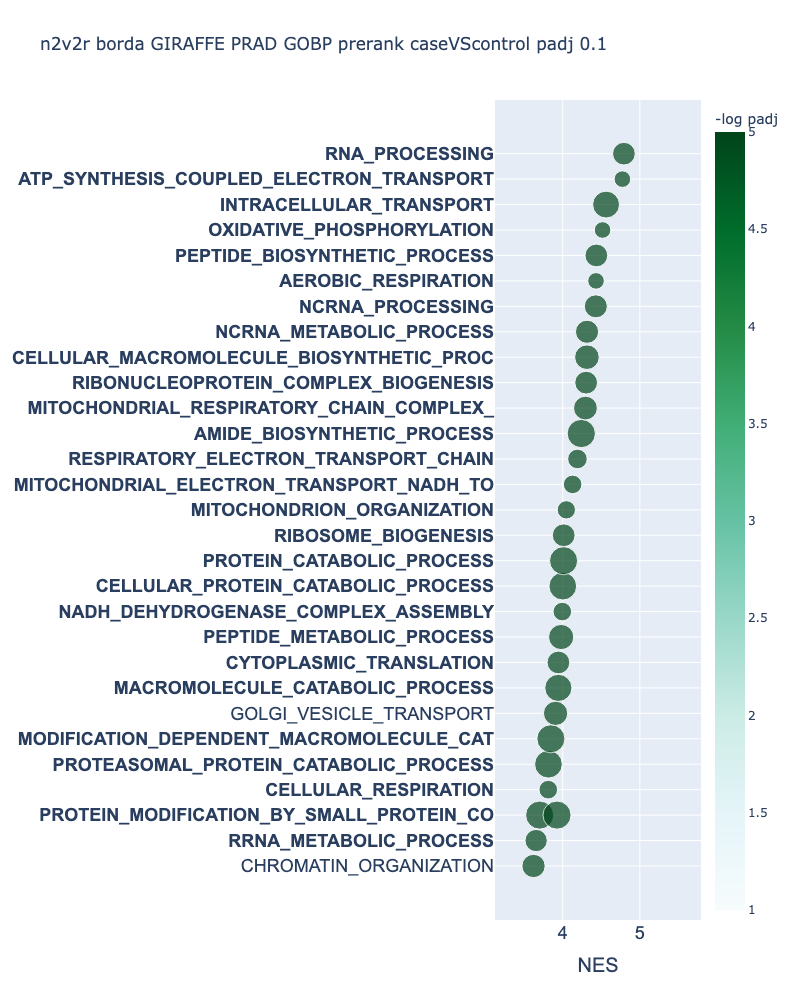

In [10]:
from node2vec2rank.post_utils import prerank_gseapy

save_results = True
n_cores=4

# the gene set library
kegg_pathway_fn = '../data/gene_set_libraries/human/c5.go.bp.v7.5.1.symbols.gmt'

# the parameters for prerank
prerank_weight = 0
prerank_min_path_size = 5
prerank_max_path_size = 1500
prerank_num_perms = 1500

n2v2r_borda_pre_KEGG_pd = prerank_gseapy(n2v2r_borda_ranking_pd, kegg_pathway_fn, prerank_weight=prerank_weight,
                                prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
absDeDi_pre_KEGG_pd = prerank_gseapy(absDeDi_ranking_pd, kegg_pathway_fn, prerank_weight=prerank_weight,
                                prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

from node2vec2rank.post_utils import plot_gseapy_prerank 

padj_cutoff = 0.1

save_directory = '.'

#Setting this to True, will allow the notebook figures to be interactive, e.g., hover over points and get more info
#Setting this to False will show the figure as png and non-interactive
#If True, the figures won't be shown when published on github, which is why we set it False here
interactive = False

title = network_inf_method+ " " +  tissue +  " GOBP prerank " + target + " padj " + str(padj_cutoff) 
to_bold_from_dedi=plot_gseapy_prerank(absDeDi_pre_KEGG_pd, has_stability=False, characters_trim=40, trim_first_num_characters=5, padj_cutoff=padj_cutoff, plot=False)['pathway'].values
to_bold_from_n2v2r_borda=plot_gseapy_prerank(n2v2r_borda_pre_KEGG_pd, has_stability=False, characters_trim=40,trim_first_num_characters=5, padj_cutoff=padj_cutoff, output_dir=save_directory,plot=False)['pathway'].values

plot_gseapy_prerank(absDeDi_pre_KEGG_pd, has_stability=False, characters_trim=40, trim_first_num_characters=5, padj_cutoff=padj_cutoff, title="absDeDi " +title, output_dir=save_directory,to_bold=to_bold_from_n2v2r_borda, interactive=interactive)
plot_gseapy_prerank(n2v2r_borda_pre_KEGG_pd, has_stability=False, characters_trim=40,trim_first_num_characters=5, padj_cutoff=padj_cutoff,  title="n2v2r borda " +title, output_dir=save_directory,to_bold=to_bold_from_dedi,interactive=interactive);

## GSEA on KEGG

2024-03-23 12:15:44,625 [WARNING] Duplicated values found in preranked stats: 3.35% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-03-23 12:15:49,639 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


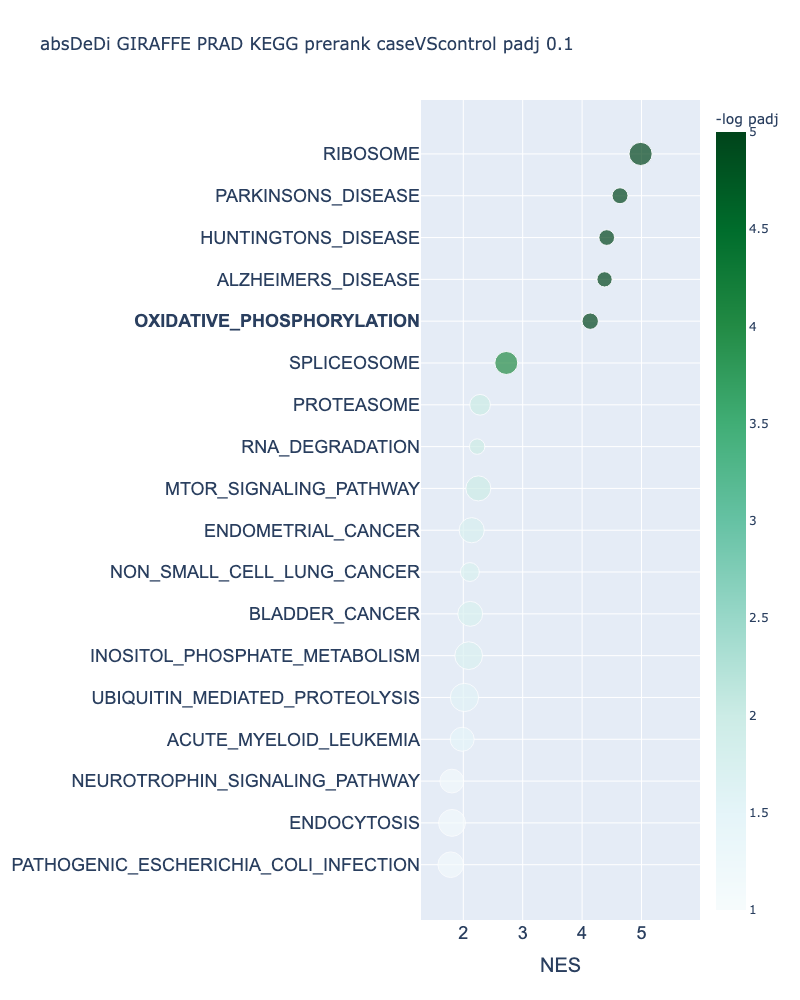

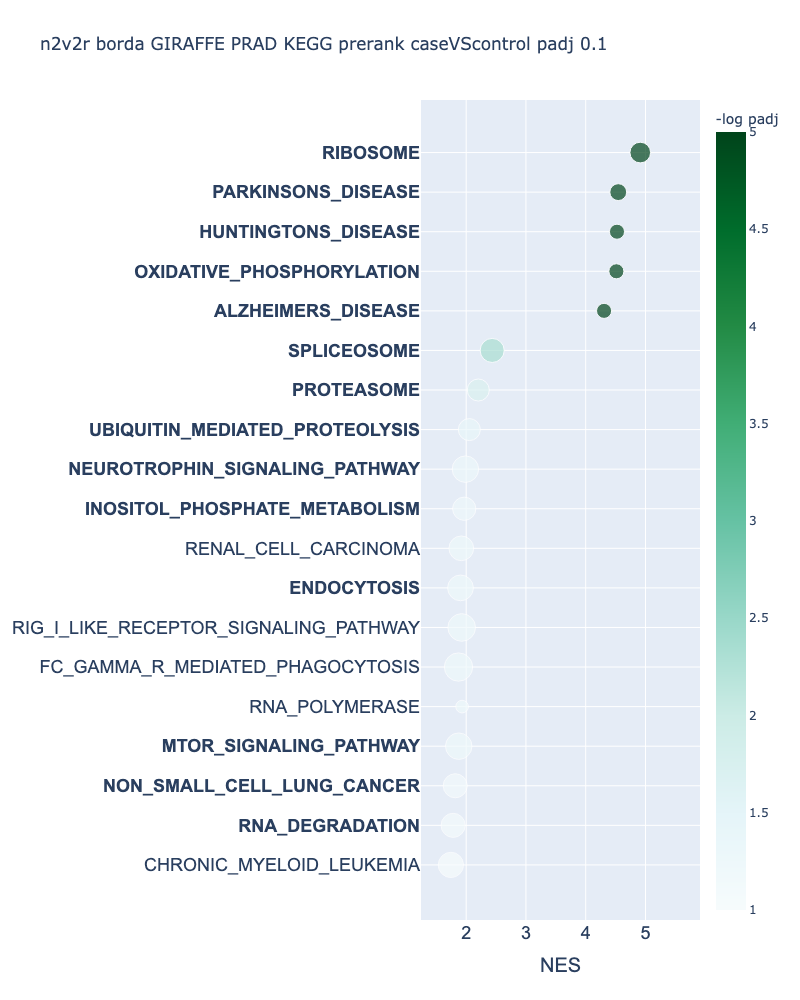

In [12]:
from node2vec2rank.post_utils import prerank_gseapy

save_results = True
n_cores=4

# the gene set library
kegg_pathway_fn = '../data/gene_set_libraries/human/c2.cp.kegg.v7.5.1.symbols.gmt'

# the parameters for prerank
prerank_weight = 0
prerank_min_path_size = 5
prerank_max_path_size = 1500
prerank_num_perms = 1500

n2v2r_borda_pre_KEGG_pd = prerank_gseapy(n2v2r_borda_ranking_pd, kegg_pathway_fn, prerank_weight=prerank_weight,
                                prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
absDeDi_pre_KEGG_pd = prerank_gseapy(absDeDi_ranking_pd, kegg_pathway_fn, prerank_weight=prerank_weight,
                                prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

from node2vec2rank.post_utils import plot_gseapy_prerank 

padj_cutoff = 0.1

save_directory = '.'

#Setting this to True, will allow the notebook figures to be interactive, e.g., hover over points and get more info
#Setting this to False will show the figure as png and non-interactive
#If True, the figures won't be shown when published on github, which is why we set it False here
interactive = False

title = network_inf_method+ " " +  tissue +  " KEGG prerank " + target + " padj " + str(padj_cutoff) 
to_bold_from_dedi=plot_gseapy_prerank(absDeDi_pre_KEGG_pd, has_stability=False, characters_trim=40, trim_first_num_characters=5, padj_cutoff=padj_cutoff, plot=False)['pathway'].values
#to_bold_from_n2v2r_borda=plot_gseapy_prerank(n2v2r_borda_pre_KEGG_pd, has_stability=False, characters_trim=40,trim_first_num_characters=5, padj_cutoff=padj_cutoff, output_dir=save_directory,plot=False)['pathway'].values

plot_gseapy_prerank(absDeDi_pre_KEGG_pd, has_stability=False, characters_trim=40, trim_first_num_characters=5, padj_cutoff=padj_cutoff, title="absDeDi " +title, output_dir=save_directory,to_bold=to_bold_from_n2v2r_borda, interactive=interactive)
plot_gseapy_prerank(n2v2r_borda_pre_KEGG_pd, has_stability=False, characters_trim=40,trim_first_num_characters=5, padj_cutoff=padj_cutoff,  title="n2v2r borda " +title, output_dir=save_directory,to_bold=to_bold_from_dedi,interactive=interactive);